# Exploratory data analysis

## Imports and setup

In [1]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import nibabel as nib

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
import sys
import os

In [2]:
# Add project root to sys path to allow for package-like imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

## Prepare data

In [3]:
# Load data
from scripts.load_data import MRIDataset

dataset = MRIDataset(root_dir="../data/lesions", labels_path="../data/lesions/PROSTATEx_Classes.csv")
print(len(dataset))

200


In [4]:
# Patient-level index for train/test split
patient_idxs = defaultdict(list)

for idx, sample in enumerate(dataset.samples):
    finding_id = sample["finding_id"]
    patient_id = finding_id.split("_Finding")[0]
    patient_idxs[patient_id].append(idx)

patient_ids = list(patient_idxs.keys())
print(f"Total patients: {len(patient_ids)}")

Total patients: 199


In [5]:
train_patients, test_patients = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=42
)

train_idxs = []
test_idxs = []

for pid in train_patients:
    train_idxs.extend(patient_idxs[pid])

for pid in test_patients:
    test_idxs.extend(patient_idxs[pid])

print(f"Train samples: {len(train_idxs)}")
print(f"Test samples: {len(test_idxs)}")

Train samples: 160
Test samples: 40


In [6]:
# Torch subsets
train_set = Subset(dataset, train_idxs)
test_set = Subset(dataset, test_idxs)

## Global dataset checks

Sanity checks for missing labels, image and mask alignment, voxel spacing, mask validity (empty or non-binary values), and shape consistency.

In [15]:
# Missing labels

def check_missing_labels(dataset):
    missing = []
    for s in dataset.samples:
        fid = s["finding_id"]
        row = dataset.labels.get(fid)
        if row is None:
            missing.append(fid)
    print(f"Missing labels: {len(missing)}")
    return missing

missing_labels = check_missing_labels(dataset)

Missing labels: 0


In [17]:
# Image-mask alignment (shape and affine)

def check_align(dataset, max_checks=50):
    mismatches = []
    for i in range(min(len(dataset), max_checks)):
        sample = dataset[i]

        img_nii = nib.load(dataset.samples[i]["image_path"])
        mask_nii = nib.load(dataset.samples[i]["mask_path"])

        if img_nii.shape != mask_nii.shape:
            mismatches.append((i, "shape"))
        
        if not np.allclose(img_nii.affine, mask_nii.affine):
            mismatches.append((i, "affine"))
    print(f"Alignment issues found in: {len(mismatches)}")
    return mismatches

alignment = check_align(dataset)

Alignment issues found in: 3


In [ ]:
# Check mismatches
Counter([m[1] for m in alignment])
sorted(set(i for i, _ in alignment))

[0, 25, 29]

Misalignment between affines indicate resampling will be needed before training. No shape mismatches are observed.

In [18]:
# Voxel spacing

def check_voxel_spacing(dataset):
    spacings = []
    for s in dataset.samples:
        nii = nib.load(s["image_path"])
        spacing = nii.header.get_zooms()[:3]
        spacings.append(spacing)

    spacings = np.array(spacings)
    print("Voxel spacing ranges:")
    print("Min:", spacings.min(axis=0))
    print("Max:", spacings.max(axis=0))
    return spacings

spacings = check_voxel_spacing(dataset)

Voxel spacing ranges:
Min: [0.3 0.3 3. ]
Max: [0.6 0.6 4.5]


In-plane spacing ranges from 0.3-0.6mm and slice thickness from 3.0-4.5mm. Images will need to be resampled to a fixed voxel spacing prior to training.

In [19]:
# Mask validity

def check_masks(dataset):
    empty = 0
    non_binary = 0

    for i in range(len(dataset)):
        mask = dataset[i]["mask"]

        if mask.sum() == 0:
            empty += 1

        unique = np.unique(mask)
        if not np.array_equal(unique, [0]) and not np.array_equal(unique, [0, 1]):
            non_binary += 1

    print(f"Empty masks: {empty}")
    print(f"Non-binary masks: {non_binary}")

check_masks(dataset)

Empty masks: 0
Non-binary masks: 0


In [20]:
# Shape consistency

def check_shapes(dataset):
    shapes = {}
    for s in dataset.samples:
        nii = nib.load(s["image_path"])
        shape = nii.shape
        shapes[shape] = shapes.get(shape, 0) + 1

    print(f"Unique shapes: {len(shapes)}")
    for k, v in list(shapes.items())[:5]:
        print(k, v)

check_shapes(dataset)

Unique shapes: 11
(384, 384, 19) 98
(384, 384, 21) 61
(384, 384, 23) 21
(384, 384, 24) 1
(384, 384, 25) 6


All images share consistent in-plane dimensions (384x384) with variations in number of slices as expected.

## Training set EDA

Label distributions and class balance, intensity distribution, lesion volume distribution, image examination

In [7]:
# Helper to iterate over train set Subset

def iter_subset(subset):
    for i in range(len(subset)):
        yield subset[i]

In [ ]:
# Clinical significance class distribution 

cls_labels = [s["cls_label"] for s in iter_subset(train_set)]
cls_counts = Counter(cls_labels)

for k, v in cls_counts.items():
    print(f"{k}: {v} ({v / len(cls_labels):.2%})")

0: 113 (70.62%)
1: 47 (29.38%)


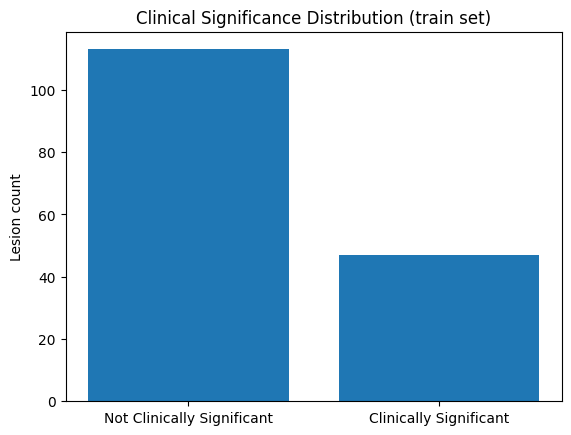

In [9]:
# Bar chart
labels = ["Not Clinically Significant", "Clinically Significant"]
values = [cls_counts[0], cls_counts[1]]

plt.figure()
plt.bar(labels, values)
plt.ylabel("Lesion count")
plt.title("Clinical Significance Distribution (train set)")
plt.show()

Roughly 70/30 class imbalance for clinical significance. Class weighting will be needed for training, and metrics such as sensitivity/recall should be used in addition to accuracy and AUC.

In [11]:
# Gleason grade group distribution

gleason_labels = [s["gleason_label"] for s in iter_subset(train_set)]
gleason_counts = Counter(gleason_labels)

for k in sorted(gleason_counts):
    print(f"G{ k }: {gleason_counts[k]}")

G-1: 91
G1: 22
G2: 29
G3: 9
G4: 4
G5: 5


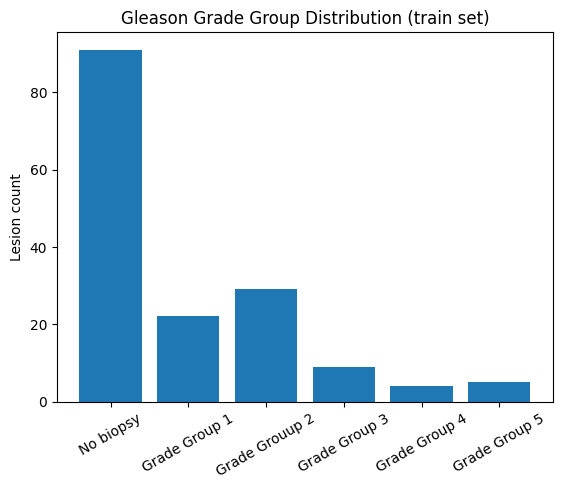

In [13]:
# Bar chart

labels = ["No biopsy", "Grade Group 1", "Grade Grouup 2", "Grade Group 3", "Grade Group 4", "Grade Group 5"]
values = [gleason_counts[k] for k in [-1, 1, 2, 3, 4, 5]]

plt.figure()
plt.bar(labels, values)
plt.ylabel("Lesion count")
plt.title("Gleason Grade Group Distribution (train set)")
plt.xticks(rotation=30)
plt.show()

Many samples have no biopsy information (G-1 = 91), with very few high-grade lesions (G4, G5). 6-class classification may not produce strong performance. Using 3 classes, e.g. benign/unknown (G1), low-grade (G1, G2), high-grade (G1, G2, G3), will likely be better.

In [28]:
# Examine intensities

def collect_intensities(subset, max_samples=20, voxels_per_sample=5000):
    intensities = []

    for i in range(min(len(subset), max_samples)):
        sample = subset[i]
        img = sample["image"][0]
        mask = sample["mask"][0] > 0

        voxels = img[mask]
        if len(voxels) == 0:
            continue

        if len(voxels) > voxels_per_sample:
            voxels = np.random.choice(voxels, voxels_per_sample, replace=False)

        intensities.append(voxels)

    return np.concatenate(intensities)

lesion_intensities = collect_intensities(train_set)

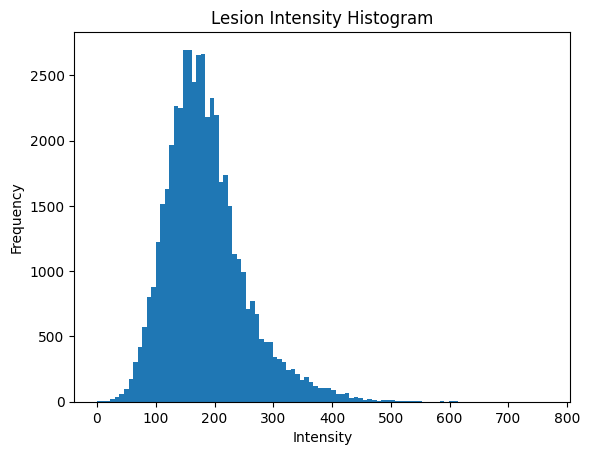

In [30]:
# Plot histogram

plt.hist(lesion_intensities, bins=100)
plt.title("Lesion Intensity Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

In [31]:
# Intensity statistics

print("Intensity statistics:")
print(f"Min: {lesion_intensities.min():.2f}")
print(f"Max: {lesion_intensities.max():.2f}")
print(f"Mean: {lesion_intensities.mean():.2f}")
print(f"Std: {lesion_intensities.std():.2f}")
print("Percentiles:", np.percentile(lesion_intensities, [1, 5, 50, 95, 99]))

Intensity statistics:
Min: 0.00
Max: 767.00
Mean: 184.87
Std: 68.02
Percentiles: [ 64.85  92.   176.   314.   399.  ]


Fairly clean and bounded distribution, with a moderately long right tail. Z-score normalization is likely better than min-max normalization which is more sensitive to outliers.

In [32]:
# Lesion volume distribution

# Compute voxel volume per sample
def lesion_volumes(subset):
    volumes = []

    for i in range(len(subset)):
        sample = subset[i]
        mask = sample["mask"][0] > 0

        if mask.sum() == 0:
            continue

        # Voxel spacing from header
        idx = train_set.indices[i]
        nii = nib.load(dataset.samples[idx]["image_path"])
        spacing = nii.header.get_zooms()[:3]

        voxel_volume = np.prod(spacing)
        lesion_volume = mask.sum() * voxel_volume
        volumes.append(lesion_volume)

    return np.array(volumes)

lesion_vols = lesion_volumes(train_set)

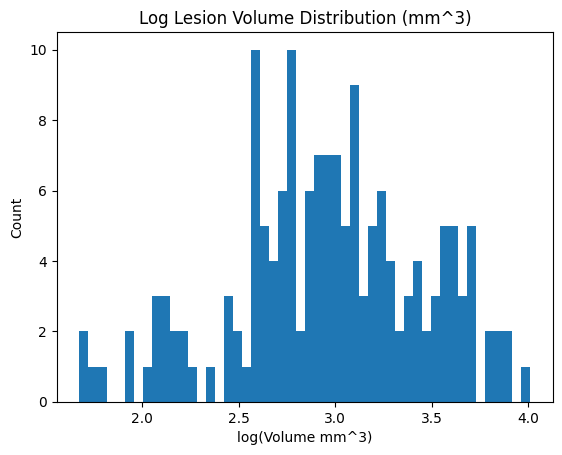

In [35]:
# Plot lesion volume distribution

plt.hist(np.log10(lesion_vols), bins=50)
plt.title("Log Lesion Volume Distribution (mm^3)")
plt.xlabel("log(Volume mm^3)")
plt.ylabel("Count")
plt.show()

In [36]:
# Volume statistics

print("Lesion volume statistics:")
print(f"Min: {lesion_vols.min():.1f}")
print(f"Median: {np.median(lesion_vols):.1f}")
print(f"Mean: {lesion_vols.mean():.1f}")
print(f"95th percentile: {np.percentile(lesion_vols, 95):.1f}")

Lesion volume statistics:
Min: 47.2
Median: 927.4
Mean: 1632.7
95th percentile: 5277.0


Strong right skew (histogram is clearer after log-transform) with many small lesions and a few large lesions. Using the whole volume may be inefficient; cropping to ROI may be better.

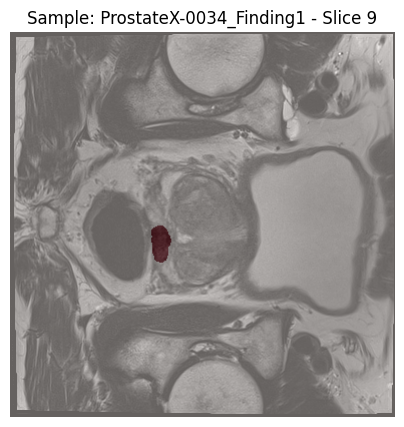

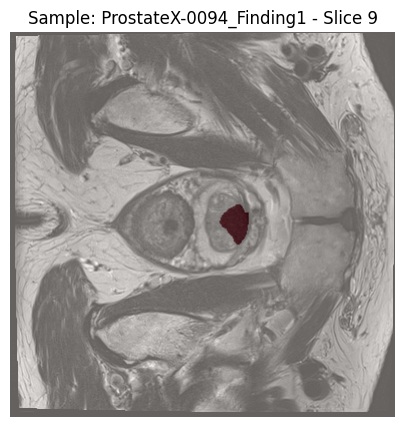

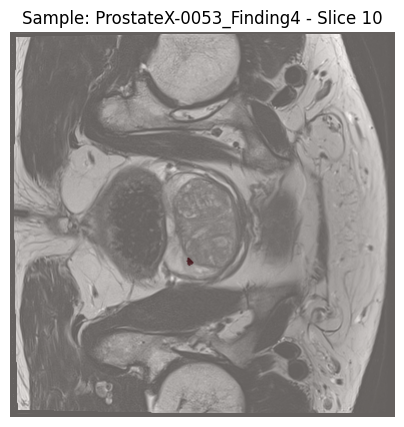

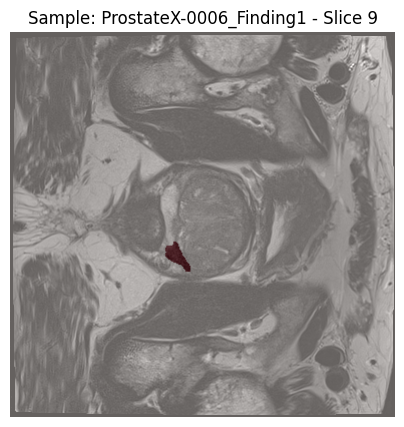

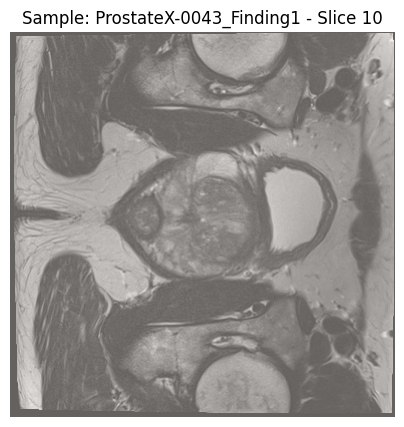

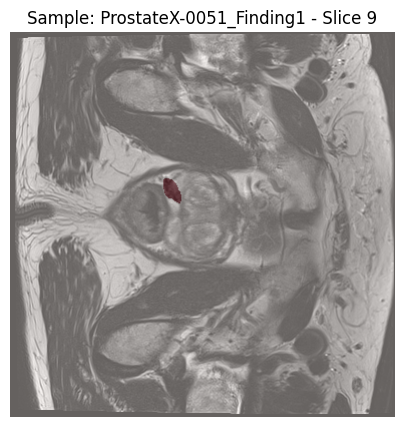

In [8]:
# Examine images

# Random indices
np.random.seed(42)
sample_indices = np.random.choice(len(train_set), size=6, replace=False)

for idx in sample_indices:
    sample = train_set[idx]
    img = sample["image"][0]
    mask = sample["mask"][0]

    # Get middle axial slice
    z = img.shape[2] // 2
    img_slice = img[:, :, z]
    mask_slice = mask[:, :, z]

    plt.figure(figsize=(5, 5))
    plt.imshow(img_slice, cmap='gray')
    plt.imshow(mask_slice, alpha=0.4, cmap="Reds")
    plt.title(f"Sample: {sample['id']} - Slice {z}")
    plt.axis('off')
    plt.show()

Note that these images are all (and only) T2 weighted axial sequences, with a generally smaller field of view to cover the prostate and seminal vesicles only, and where zonal anatomy (transition zone and peripheral zone) is visible. Specifically, in the transition zone (TZ), any changes in glandular and stromal benign prostatic hyperplasia (BPH) and abnormalities or suspicious lesions are typically looked for. In the peripheral zone (PZ), where the majority of cancer occurs (~75%), any focal abnormalities, e.g. hyperintensity, are identified.